In [275]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import WhitespaceTokenizer

Read data - Q1:

In [276]:
df = pd.read_csv("spam_ham_dataset.csv")
df_sub = df['text']

Perform tokenize - Q2:

In [277]:
for i in df['text']:
    word_tokenize(i)

In [278]:
for i in df['text']:
    wordpunct_tokenize(i)

In [279]:
for i in df['text']:
    WhitespaceTokenizer().tokenize(i)

Perform EDA - Q3:

In [280]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [281]:
df["label"].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [282]:
df['label_num'].value_counts()

0    3672
1    1499
Name: label_num, dtype: int64

In [283]:
df['text'].value_counts()

Subject: calpine daily gas nomination\r\n>\r\nricky a . archer\r\nfuel supply\r\n700 louisiana , suite 2700\r\nhouston , texas 77002\r\n713 - 830 - 8659 direct\r\n713 - 830 - 8722 fax\r\n- calpine daily gas nomination 1 . doc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [284]:
df['text'].isna().sum()

0

In [285]:
spam = df[df.label_num == 1].shape[0]
ham = df[df.label_num == 0].shape[0]

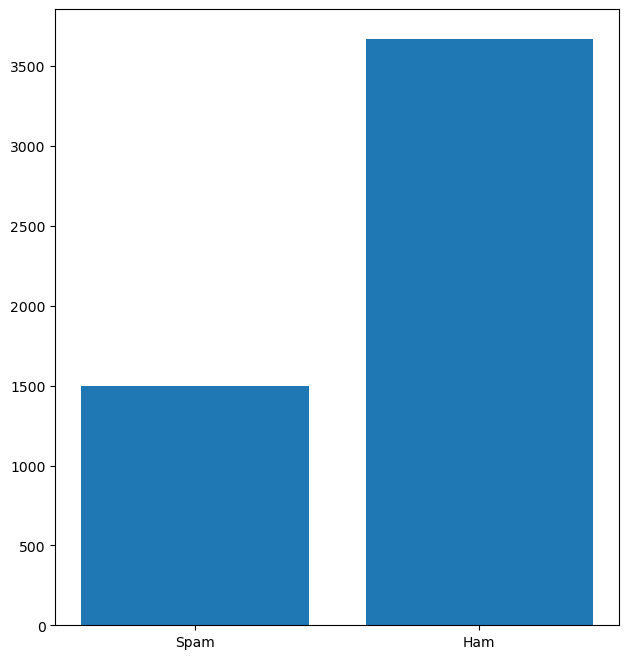

In [286]:
plt.figure(1,figsize=(16,8))
plt.subplot(1,2,1)
_ = plt.bar(['Spam', 'Ham'], [spam, ham])

In [287]:
def plot_target_based_features(feature):
    x1 = df[df.label_num == 1][feature]
    x2 = df[df.label_num == 0][feature]
    plt.figure(1, figsize=(16,8))
    plt.subplot(1,1,1)
    _ = plt.hist(x2, alpha=0.5, color="grey", bins=70)
    _ = plt.hist(x1, alpha=0.7, color="red", bins=70)
    return _

In [288]:
df["text_len"] = df.text.map(lambda x: len(x))

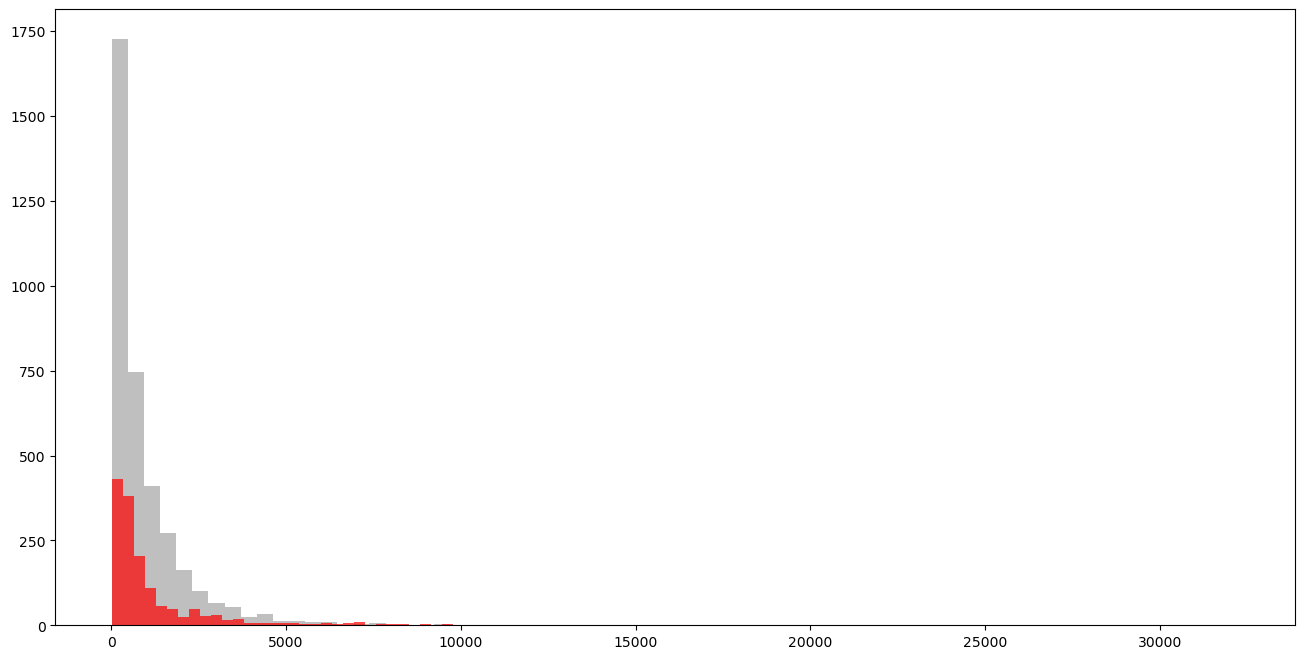

In [289]:
_ = plot_target_based_features("text_len")

In [290]:
df["words_count"] = df.text.str.split().map(lambda x: len(x))

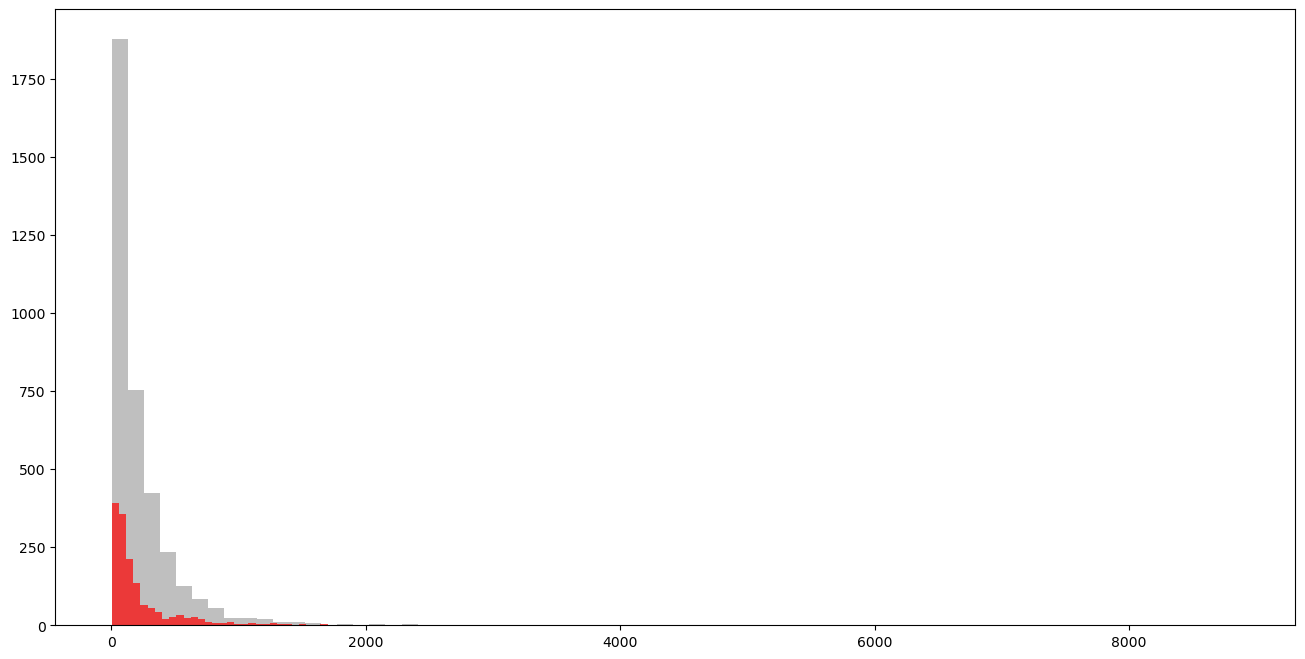

In [291]:
_ = plot_target_based_features("words_count")

In [292]:
df["unique_word_count"] = df.text.map(lambda x: len(set(str(x).split())))

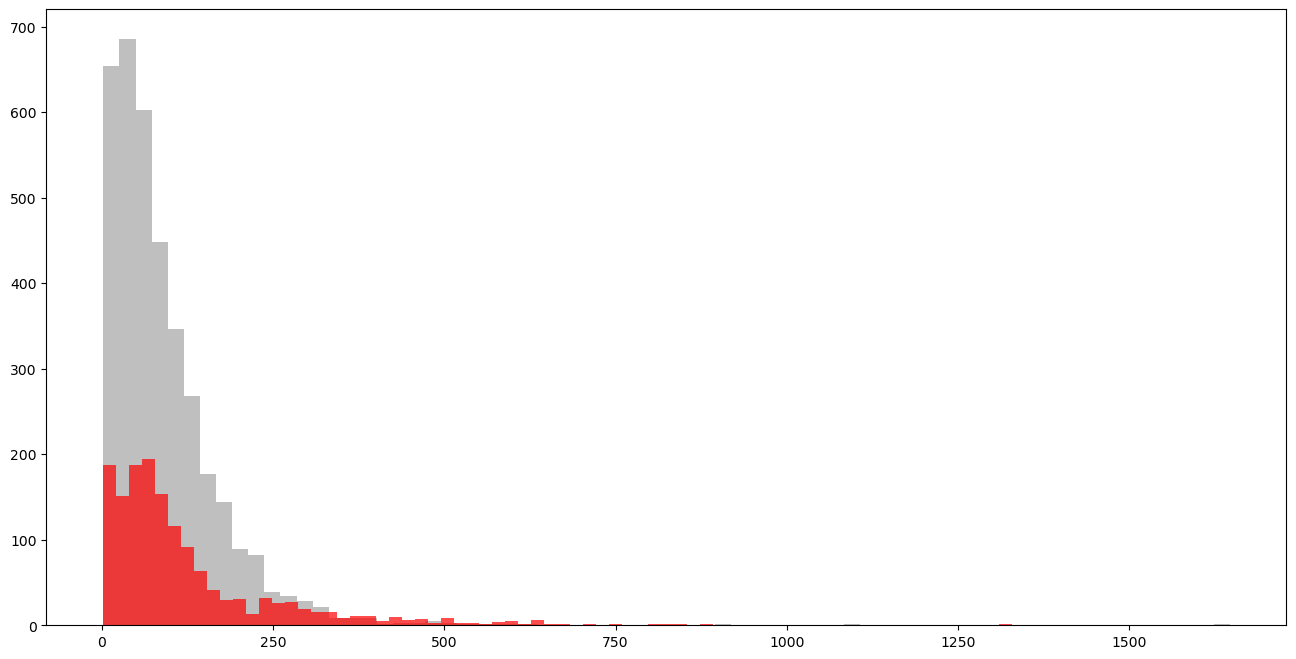

In [293]:
_ = plot_target_based_features("unique_word_count")

In [294]:
import string

df['punctuation_count'] = df["text"].map(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)

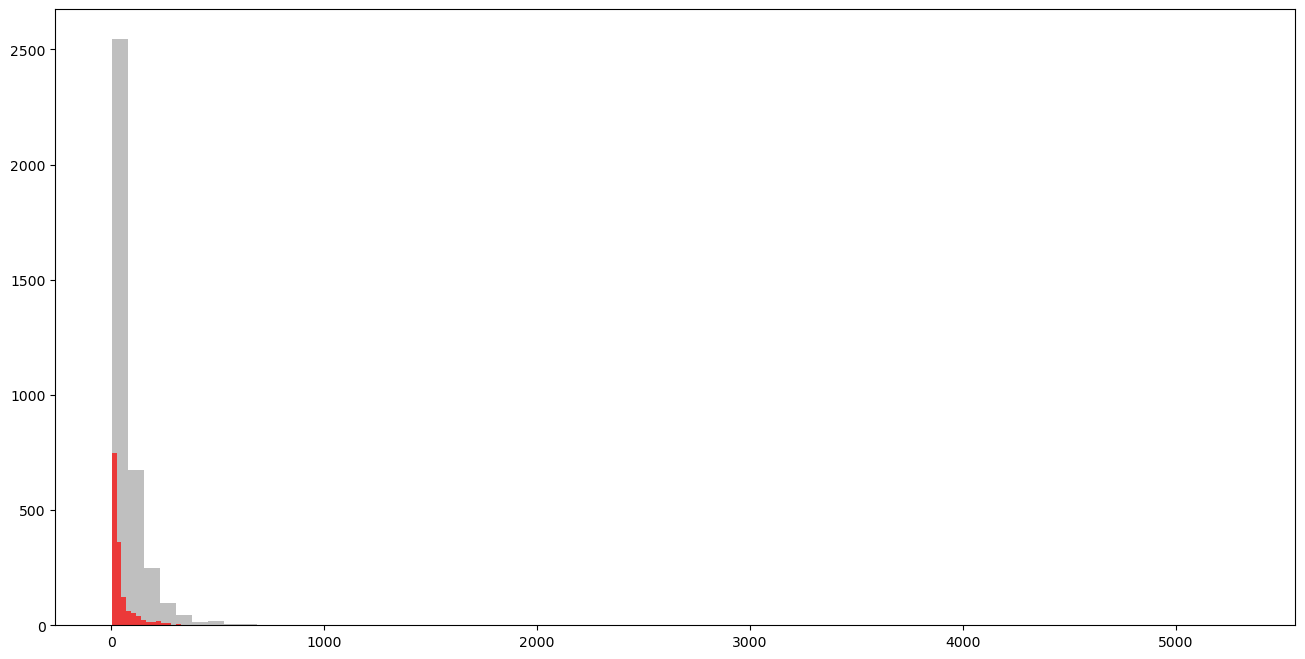

In [295]:
_ = plot_target_based_features("punctuation_count")

Prepare the data - Q4:

In [296]:
def normalize_target_column(x):
    return 1 if x=="ham" else 0

In [297]:
df['label_normalized'] = df['label'].apply(lambda x:normalize_target_column(x))

#split the data to train & test

In [298]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=1)

In [299]:
print(f"Dataset is split into train ser of {train.shape[0]} records and {test.shape[0]} records.")

Dataset is split into train ser of 4136 records and 1035 records.


Remove all null values

In [300]:
train_text = train[~pd.isnull(train['text'])]['text']
test_text = test[~pd.isnull(test['text'])]['text']

Transform text to features

In [301]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer()

In [302]:
TF_IDF_matrix_input_train = vectorizer.fit_transform(train_text)
#TF_IDF_matrix_input_train = vectorizer.transform(train_text)
print(f"Train set input has {TF_IDF_matrix_input_train.shape[0]} records and {TF_IDF_matrix_input_train.shape[1]} features.")

Train set input has 4136 records and 44759 features.


In [303]:
#TF_IDF_matrix_input_test_fit = vectorizer.fit_transform(test_text)
TF_IDF_matrix_input_test = vectorizer.transform(test_text)
print(f"Test set input has {TF_IDF_matrix_input_test.shape[0]} records and {TF_IDF_matrix_input_test.shape[1]} features.")

Test set input has 1035 records and 44759 features.


In [304]:
feature_names = vectorizer.get_feature_names_out()

Expected output for train & test

In [305]:
expected_output_train = train[~pd.isnull(train['text'])]['label_normalized']
expected_output_test = test[~pd.isnull(test['text'])]['label_normalized']

Train Classifier

In [306]:
from sklearn.linear_model import LogisticRegression
classifier_LG = LogisticRegression(C=5, max_iter=1000)

In [307]:
classifier_LG.fit(TF_IDF_matrix_input_train, expected_output_train)

LogisticRegression(C=5, max_iter=1000)

In [308]:
predictions_LG = classifier_LG.predict(TF_IDF_matrix_input_test)

In [309]:
from sklearn import metrics
recall_LG = metrics.recall_score(expected_output_test, predictions_LG)
print("recall for Logistic Regression =", recall_LG)

recall for Logistic Regression = 0.9890560875512996


In [310]:
precision_LG = metrics.precision_score(expected_output_test, predictions_LG)
print("precision for Logistic Regression =", precision_LG)

precision for Logistic Regression = 0.9944979367262724


In [311]:
accuracy_LG = metrics.accuracy_score(expected_output_test, predictions_LG)
print("accuracy for Logistic Regression =", accuracy_LG)

accuracy for Logistic Regression = 0.9884057971014493


New run with different algorithm - #1 KNN:

In [312]:
import math
k = int(math.sqrt(train['label_normalized'].shape[0]/2))
if k % 2 == 0:
    k += 1

print("the K value is", k)

the K value is 45


In [313]:
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier(n_neighbors=k)
classifier_KNN.fit(TF_IDF_matrix_input_train, expected_output_train)

KNeighborsClassifier(n_neighbors=45)

In [314]:
predictions_KNN = classifier_KNN.predict(TF_IDF_matrix_input_test)

/Users/agamil/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [315]:
recall_KNN = metrics.recall_score(expected_output_test, predictions_KNN)
print("recall for KNN =", recall_KNN)

recall for KNN = 0.9753761969904241


In [316]:
precision_KNN = metrics.precision_score(expected_output_test, predictions_KNN)
print("precision for KNN =", precision_KNN)

precision for KNN = 0.9418758256274768


In [317]:
accuracy_KNN = metrics.accuracy_score(expected_output_test, predictions_KNN)
print("accuracy for KNN =", accuracy_KNN)

accuracy for KNN = 0.9400966183574879


New run with different algorithm - #2 Decision Tree:

[Text(0.6785714285714286, 0.9166666666666666, 'X[16758] <= 0.002\ngini = 0.411\nsamples = 4136\nvalue = [1195, 2941]\nclass = ham'),
 Text(0.6071428571428571, 0.75, 'X[21983] <= 0.002\ngini = 0.482\nsamples = 2952\nvalue = [1195, 1757]\nclass = ham'),
 Text(0.35714285714285715, 0.5833333333333334, 'X[39903] <= 0.016\ngini = 0.438\nsamples = 2512\nvalue = [815, 1697]\nclass = ham'),
 Text(0.21428571428571427, 0.4166666666666667, 'X[21899] <= 0.006\ngini = 0.486\nsamples = 1927\nvalue = [803, 1124]\nclass = ham'),
 Text(0.14285714285714285, 0.25, 'X[38756] <= 0.023\ngini = 0.5\nsamples = 1602\nvalue = [803, 799]\nclass = spam'),
 Text(0.07142857142857142, 0.08333333333333333, 'gini = 0.424\nsamples = 701\nvalue = [487, 214]\nclass = spam'),
 Text(0.21428571428571427, 0.08333333333333333, 'gini = 0.455\nsamples = 901\nvalue = [316, 585]\nclass = ham'),
 Text(0.2857142857142857, 0.25, 'gini = 0.0\nsamples = 325\nvalue = [0, 325]\nclass = ham'),
 Text(0.5, 0.4166666666666667, 'X[29477] <= 0

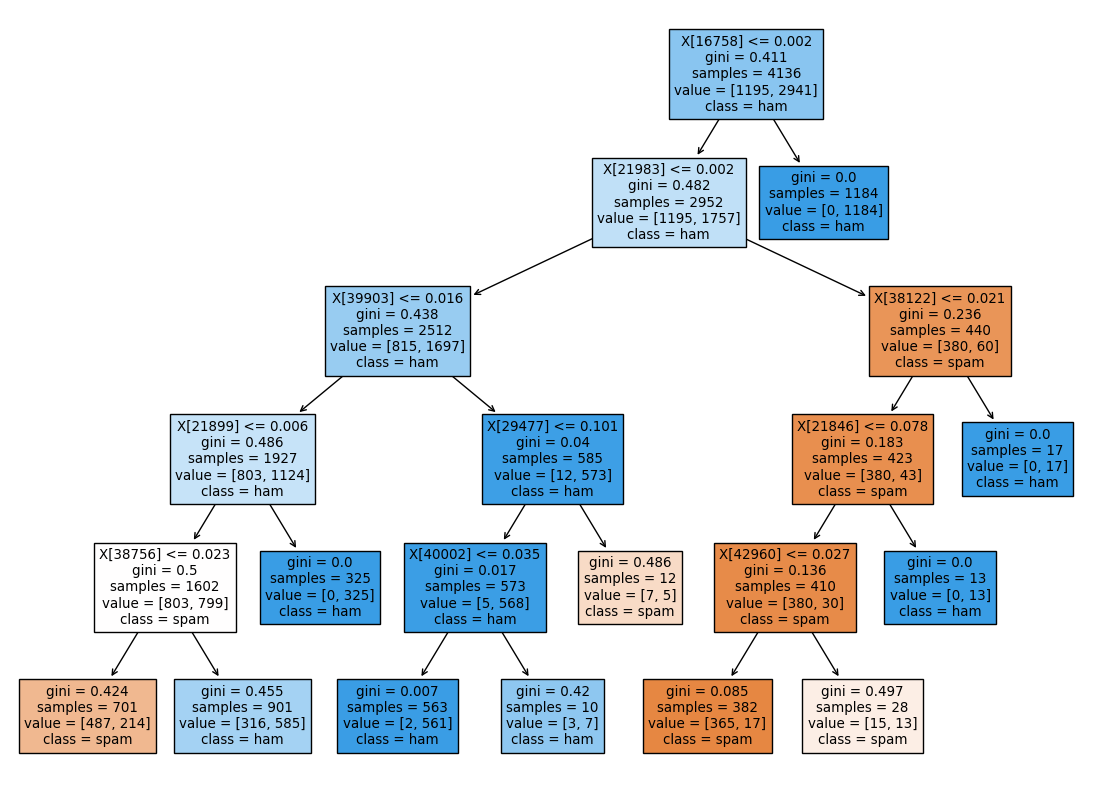

In [318]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=1)
model = clf.fit(TF_IDF_matrix_input_train, expected_output_train)

fig = plt.figure(figsize=(14,10))
tree.plot_tree(model, class_names=['spam', 'ham'], filled=True)

In [319]:
predictions_DT = model.predict(TF_IDF_matrix_input_test)

In [320]:
recall_DT = metrics.recall_score(expected_output_test, predictions_DT)
print("recall for Decision Tree =", recall_DT)
precision_DT = metrics.precision_score(expected_output_test, predictions_DT)
print("precision for Decision Tree =", precision_DT)
accuracy_DT = metrics.accuracy_score(expected_output_test, predictions_DT)
print("accuracy for Decision Tree =", accuracy_DT)

recall for Decision Tree = 0.9001367989056087
precision for Decision Tree = 0.8623853211009175
accuracy for Decision Tree = 0.8280193236714976


New run with different features - #3 Logistic regression:

In [321]:
train_2, test_2 = train_test_split(df, test_size=0.3, random_state=3)
print(f"Dataset is split into train ser of {train_2.shape[0]} records and {test_2.shape[0]} records.")

Dataset is split into train ser of 3619 records and 1552 records.


In [322]:
train_2_text = train_2[~pd.isnull(train_2['text'])]['text']
test_2_text = test_2[~pd.isnull(test_2['text'])]['text']

In [323]:
vectorizer = TfidfVectorizer()
TF_IDF_matrix_input_train_2 = vectorizer.fit_transform(train_2_text)
#TF_IDF_matrix_input_train_2 = vectorizer.transform(train_text)
print(f"Train set input has {TF_IDF_matrix_input_train.shape[0]} records and {TF_IDF_matrix_input_train_2.shape[1]} features.")
#TF_IDF_matrix_input_test_2 = vectorizer.fit_transform(test_text)
TF_IDF_matrix_input_test_2 = vectorizer.transform(test_2_text)
print(f"Test set input has {TF_IDF_matrix_input_test.shape[0]} records and {TF_IDF_matrix_input_test.shape[1]} features.")

Train set input has 4136 records and 41719 features.
Test set input has 1035 records and 44759 features.


In [324]:
feature_names = vectorizer.get_feature_names_out()
expected_output_train_2 = train_2[~pd.isnull(train_2['text'])]['label_normalized']
expected_output_test_2 = test_2[~pd.isnull(test_2['text'])]['label_normalized']

In [325]:
classifier_LG_2 = LogisticRegression(C=5, max_iter=1000)
classifier_LG_2.fit(TF_IDF_matrix_input_train_2, expected_output_train_2)
predictions_LG_2 = classifier_LG_2.predict(TF_IDF_matrix_input_test_2)

In [326]:
recall_LG_2 = metrics.recall_score(expected_output_test_2, predictions_LG_2)
print("recall for Logistic Regression =", recall_LG_2)
precision_LG_2 = metrics.precision_score(expected_output_test_2, predictions_LG_2)
print("precision for Logistic Regression =", precision_LG_2)
accuracy_LG_2 = metrics.accuracy_score(expected_output_test_2, predictions_LG_2)
print("accuracy for Logistic Regression =", accuracy_LG_2)

recall for Logistic Regression = 0.9801084990958409
precision for Logistic Regression = 0.9944954128440368
accuracy for Logistic Regression = 0.9819587628865979


Final results - Q8:

In [327]:
data = {"results": ["recall", "precision", "accuracy"],
        "logistic regression #1": [recall_LG, precision_LG, accuracy_LG],
        "KNN":[recall_KNN, precision_KNN, accuracy_KNN],
        "Decision tree": [recall_DT, precision_DT, accuracy_DT],
        "logistic regression #2": [recall_LG_2, precision_LG_2, accuracy_LG_2]}
results = pd.DataFrame(data)

results

,results,logistic regression #1,KNN,Decision tree,logistic regression #2
0,recall,0.989056,0.975376,0.900137,0.980108
1,precision,0.994498,0.941876,0.862385,0.994495
2,accuracy,0.988406,0.940097,0.828019,0.981959


The best result - Q9:

In [328]:
print("best results was with KNN algorithm with the higly accurate predictions. The algorithm predicts the data by the K value that was chosen."
      "If we choose a different K, the results will be different.")

best results was with KNN algorithm with the higly accurate predictions. The algorithm predicts the data by the K value that was chosen.If we choose a different K, the results will be different.
